<a href="https://colab.research.google.com/github/shunya-yan/colab/blob/main/adversarial_example_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# データの準備、動作確認など


# 新しいセクション

In [ ]:
!wget -O AI_data.zip https://www.dropbox.com/scl/fi/gareuvjxrlwgeg0yzljay/AI_data.zip?rlkey=gx0qog3y983rmvzbvq1mah8i8&st=gpbir2kj&dl=0
!unzip /content/AI_data.zip

--2024-07-12 06:46:51--  https://www.dropbox.com/scl/fi/gareuvjxrlwgeg0yzljay/AI_data.zip?rlkey=gx0qog3y983rmvzbvq1mah8i8
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca61d9b86b6d4b98fc6c3559b56.dl-jp.dropboxusercontent.com/cd/0/inline/CWjXtyyzhlxezq-MjjJZZ6aNJJkA8J0LnvrBMeotMiuGLV8vOeF-SzrsFhU9re6oDjQA9NoS3R7TBo86yS6J0E466XO33j41su9WK1Qoxv-hVD3b-lVlIWZx8-sUiioOZJFZ84LAn25PQqs7R91TKKsX/file# [following]
--2024-07-12 06:46:52--  https://uca61d9b86b6d4b98fc6c3559b56.dl-jp.dropboxusercontent.com/cd/0/inline/CWjXtyyzhlxezq-MjjJZZ6aNJJkA8J0LnvrBMeotMiuGLV8vOeF-SzrsFhU9re6oDjQA9NoS3R7TBo86yS6J0E466XO33j41su9WK1Qoxv-hVD3b-lVlIWZx8-sUiioOZJFZ84LAn25PQqs7R91TKKsX/file
Resolving uca61d9b86b6d4b98fc6c3559b56.dl-jp.dropboxusercontent.com (uca61d9b86b6d4b98fc6c3559b56.dl-jp.dropboxusercontent.com)... 162.125.2

In [ ]:
!wget -O cube_classifier.pth https://www.dropbox.com/scl/fi/cfxel8m426vh2nx7sp9ee/cube_classifier.pth?rlkey=gfun3uad7gh8x9h4d4htr7lfs&st=zp3vx894&dl=0

--2024-07-12 06:46:56--  https://www.dropbox.com/scl/fi/cfxel8m426vh2nx7sp9ee/cube_classifier.pth?rlkey=gfun3uad7gh8x9h4d4htr7lfs
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8e3ed08c47b0fa496c62801a32.dl-jp.dropboxusercontent.com/cd/0/inline/CWh-tM8xC4hBHsFuqAHNUfjbqoNwpWXWVYQP7FyYaNm8AteVP3LT8uW8ErDbaTGziVU9o3n2sy-7QN5Q7QHx4POrs_bbqddHzB8ObqnIUxDy6UO-5HgEcQmAvwtpVQPf9SprRy5Nuhmo_ob4q-1EUG0f/file# [following]
--2024-07-12 06:46:57--  https://uc8e3ed08c47b0fa496c62801a32.dl-jp.dropboxusercontent.com/cd/0/inline/CWh-tM8xC4hBHsFuqAHNUfjbqoNwpWXWVYQP7FyYaNm8AteVP3LT8uW8ErDbaTGziVU9o3n2sy-7QN5Q7QHx4POrs_bbqddHzB8ObqnIUxDy6UO-5HgEcQmAvwtpVQPf9SprRy5Nuhmo_ob4q-1EUG0f/file
Resolving uc8e3ed08c47b0fa496c62801a32.dl-jp.dropboxusercontent.com (uc8e3ed08c47b0fa496c62801a32.dl-jp.dropboxusercontent.com)... 1

In [ ]:
from skimage import io
import matplotlib.pyplot as plt
from torchvision import transforms
import PIL
import copy
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

img_array = io.imread("/content/AI_data/test/block (1).jpg")


composed =transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

def plot_img_from_normalized_img(img_array, is_normalized=False):
    img_to_be_plotted = copy.deepcopy(img_array)
    assert len(img_array.shape) == 3
    if img_to_be_plotted.shape[0] == 3:
        img_to_be_plotted = img_to_be_plotted.transpose(1, 2, 0)
    if is_normalized:
        for idx, (m, v) in enumerate(zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):
            img_to_be_plotted[:, :, idx] = (img_to_be_plotted[:, :, idx] * v) + m
    plt.figure()
    plt.imshow(img_to_be_plotted)
    plt.show()

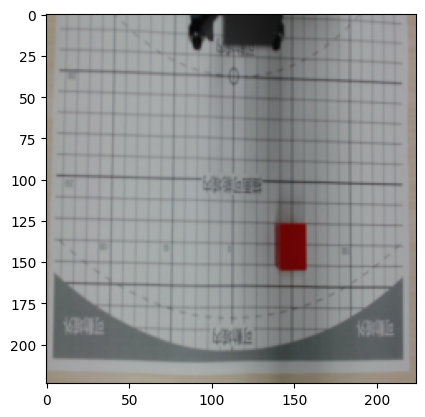

In [ ]:
transformed_img = composed(PIL.Image.fromarray(img_array))
plot_img_from_normalized_img(transformed_img.detach().numpy())

# AIモデルの定義

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import os

class CubeDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.image_paths = []
        for filename in os.listdir(self.root_dir):
            if filename.endswith(".jpg"):
                self.image_paths.append(os.path.join(self.root_dir, filename))

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img)

        # ボトルの色に基づいてラベルを設定
        label = self.get_label_from_path(img_path)

        return img_tensor, label

    def get_label_from_path(self, path):
        color_mapping = {
            "red": 0,
            "blue": 1,
        }
        for color in color_mapping:
            if color in path:
                return color_mapping[color]

        return -1  # エラーラベル
class CubeClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CubeClassifier, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## モデルの精度を検証（攻撃されていない状態）

In [ ]:
# テストコード
import torch.nn.functional as F

# モデルのパラメータを保存したチェックポイントファイルへのパス
checkpoint_path = 'cube_classifier.pth'
# テスト画像へのパス
test_image_path = '/content/AI_data/test/block (1).jpg'
# 各クラスの名前
classes = ['red', 'blue']

# 画像を読み込む
image = Image.open(test_image_path)
image = composed(image)
image = image.unsqueeze(0)  # バッチサイズの次元を追加する

# モデルを定義する
test_model = CubeClassifier(num_classes=2)
criterion = nn.CrossEntropyLoss()
# 重みを読み込む
test_model.load_state_dict(torch.load(checkpoint_path))

# 推論を行う
test_model.eval()
with torch.no_grad():
    # モデルに入力し、予測を取得する
    output = test_model(image)
    probabilities = F.softmax(output, dim=1)
    probabilities_np = probabilities.numpy()
    probabilities_np_rounded = np.round(probabilities_np*100, 2)

    blue_prob = probabilities_np_rounded[0][1]
    red_prob = probabilities_np_rounded[0][0]
    print(f"青の確率: {blue_prob}%, 赤の確率: {red_prob}%")

    predicted_class = torch.argmax(probabilities, dim=1).item()

# 結果を表示する
print(f"Class: {classes[predicted_class]}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.7MB/s]


青の確率: 0.009999999776482582%, 赤の確率: 99.98999786376953%
Class: red


# FGSMに対するAdversarial exampleの実行

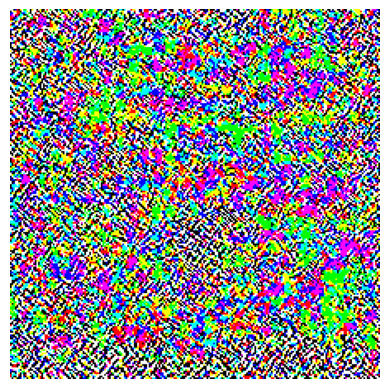

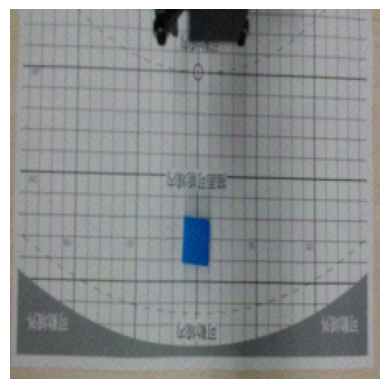

青の確率: 49.8129997253418%, 赤の確率: 50.1870002746582%
Class: red


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np

# FGSM攻撃を行う関数
def fgsm_attack(model, images, labels, eps):
    images.requires_grad = True

    #モデルによる予測
    outputs = model(images)

    #損失の計算
    cost = criterion(outputs, labels)

    #画像の各ピクセルが損失関数に与える影響を計算
    cost.backward()

    #ノイズを生成
    noise = eps * images.grad.sign()

    #ノイズを画像に加える
    attack_images = images + noise
    attack_images = torch.clamp(attack_images, 0, 1).detach_()

    return noise, attack_images

# 画像を表示および保存する関数
def show_and_save_perturbed_image(perturbed_data, save_path):
    import matplotlib.pyplot as plt
    import torchvision.transforms as T

    # テンソルを画像に変換
    to_pil = T.ToPILImage()
    perturbed_image = to_pil(perturbed_data.squeeze(0))

    # 画像を表示
    plt.imshow(perturbed_image)
    plt.axis('off')
    plt.show()

    # 画像を保存
    perturbed_image.save(save_path)

# 画像を表示および保存する関数
def show_and_save_image(image_tensor, save_path):
    to_pil = transforms.ToPILImage()
    image = to_pil(image_tensor.squeeze(0))

    # 画像を表示
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # 画像を保存
    image.save(save_path)

# モデルを定義する
test_model = CubeClassifier(num_classes=2)
test_model.load_state_dict(torch.load(checkpoint_path))
test_model.eval()


# ノイズの強度を指定する
eps = 0.0131

# 画像を読み込む
test_image_path = '/content/AI_data/test/block (11).jpg'
image = Image.open(test_image_path)
image_tensor = composed(image).unsqueeze(0)# デバイスに移動

# ラベルを設定
label = torch.tensor([1])  # デバイスに移動

# FGSM攻撃を行う
noise, perturbed_data = fgsm_attack(test_model, image_tensor, label, eps)


# 攻撃された画像を表示および保存
# ノイズ画像とノイズが加わった画像を表示および保存
show_and_save_image(noise, "noise_image.jpg")
show_and_save_perturbed_image(perturbed_data, "/content/adversarial_red_fgsm.jpg")

# 推論を行う
with torch.no_grad():

    output_perturbed = test_model(perturbed_data)

    probabilities_perturbed = F.softmax(output_perturbed, dim=1)

    probabilities_perturbed_np = probabilities_perturbed.cpu().numpy()

    probabilities_perturbed_np_rounded = np.round(probabilities_perturbed_np * 100, 3)
    blue_prob = probabilities_perturbed_np_rounded[0][1]
    red_prob = probabilities_perturbed_np_rounded[0][0]
    print(f"青の確率: {blue_prob}%, 赤の確率: {red_prob}%")
    predicted_class_perturbed = torch.argmax(probabilities_perturbed, dim=1).item()

# 結果を表示する

print(f"Class: {classes[predicted_class_perturbed]}")


# 道路標識判別AIに対する攻撃

In [ ]:
!wget -O traffic_sign.zip https://www.dropbox.com/scl/fi/ey65io1u3qf5wop6zikw4/traffic_sign.zip?rlkey=w0heo6ddkji97nn0wkm0b1h4v&st=5elx9ppi&dl=0
!unzip /content/traffic_sign.zip

--2024-07-12 06:53:39--  https://www.dropbox.com/scl/fi/ey65io1u3qf5wop6zikw4/traffic_sign.zip?rlkey=w0heo6ddkji97nn0wkm0b1h4v
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc86478c921c08a26eeb0d930414.dl-jp.dropboxusercontent.com/cd/0/inline/CWiA0yqMjpea4P_qkQ-a-MLuiQueLkol6XC1DtRJcoR4pHf44_OViLKu-TBhY29eBLCtSzBih-ekUsgDeSOymcjIUQ6SzC2yVJGTmk4L5D6tHDBbLhWhrKZupmlREJBn01FqS6Pv3emFq_E1kU7rsZhe/file# [following]
--2024-07-12 06:53:39--  https://uc86478c921c08a26eeb0d930414.dl-jp.dropboxusercontent.com/cd/0/inline/CWiA0yqMjpea4P_qkQ-a-MLuiQueLkol6XC1DtRJcoR4pHf44_OViLKu-TBhY29eBLCtSzBih-ekUsgDeSOymcjIUQ6SzC2yVJGTmk4L5D6tHDBbLhWhrKZupmlREJBn01FqS6Pv3emFq_E1kU7rsZhe/file
Resolving uc86478c921c08a26eeb0d930414.dl-jp.dropboxusercontent.com (uc86478c921c08a26eeb0d930414.dl-jp.dropboxusercontent.com)... 162.

In [ ]:
!wget -O traffic_sign_classifier.pth https://www.dropbox.com/scl/fi/fleuvaqeshap715bk47lh/traffic_sign_classifier.pth?rlkey=imxj0su0o0nl9cc8a2pps0icy&st=kytep0na&dl=0

--2024-07-12 06:53:48--  https://www.dropbox.com/scl/fi/fleuvaqeshap715bk47lh/traffic_sign_classifier.pth?rlkey=imxj0su0o0nl9cc8a2pps0icy
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc711858178dcb69e6abf8135a6f.dl-jp.dropboxusercontent.com/cd/0/inline/CWjDALrkyq4QDqmcplMr6WkGqE3WpxeuGTvCxscH_4qv-d3jSrjPyS33sYMKj698sBbvjz9v8o0sLc5ZVo4YA24uEtMgv2w1HIdin0oYO1i2JzloKlrv4k-tllyydCQpnO8lmr4j9Lctajsvwke-V9er/file# [following]
--2024-07-12 06:53:48--  https://uc711858178dcb69e6abf8135a6f.dl-jp.dropboxusercontent.com/cd/0/inline/CWjDALrkyq4QDqmcplMr6WkGqE3WpxeuGTvCxscH_4qv-d3jSrjPyS33sYMKj698sBbvjz9v8o0sLc5ZVo4YA24uEtMgv2w1HIdin0oYO1i2JzloKlrv4k-tllyydCQpnO8lmr4j9Lctajsvwke-V9er/file
Resolving uc711858178dcb69e6abf8135a6f.dl-jp.dropboxusercontent.com (uc711858178dcb69e6abf8135a6f.dl-jp.dropboxusercontent.c

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import os

class TrafficSignDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.image_paths = []
        for filename in os.listdir(self.root_dir):
            if filename.endswith(".jpg"):
                self.image_paths.append(os.path.join(self.root_dir, filename))

    def __len__(self):
        return len(self.image_paths)


    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img)


        label = self.get_label_from_path(img_path)

        return img_tensor, label

    def get_label_from_path(self, path):
        color_mapping = {
            "stop": 0,
            "speed_limit_30": 1,
        }
        for color in color_mapping:
            if color in path:
                return color_mapping[color]

        return -1  # エラーラベル
class TrafficSignClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TrafficSignClassifier, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

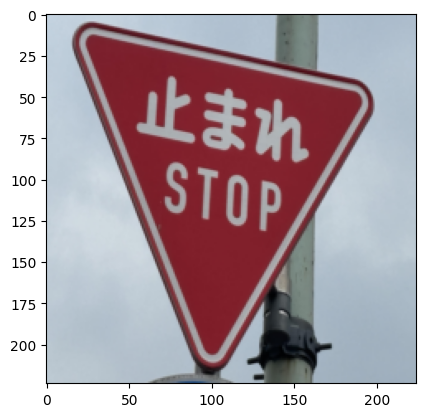

止まれの確率: 69.35299682617188%, 速度制限30km: 30.64699935913086%
予測結果: 止まれ


In [ ]:
# モデルのパラメータを保存したチェックポイントファイルへのパス
checkpoint_path = 'traffic_sign_classifier.pth'
# モデルを定義する
traffic_sign_model = TrafficSignClassifier(num_classes=2)
criterion = nn.CrossEntropyLoss()
# 重みを読み込む
traffic_sign_model.load_state_dict(torch.load(checkpoint_path))

# 各クラスの名前
classes = ['止まれ', '速度制限30km']

# テスト画像へのパス
test_image_path = '/content/traffic_sign/test/stop.jpg' # 止まれの標識のテストデータを使用する場合

# 画像を読み込む
image = Image.open(test_image_path)
image = composed(image)
plot_img_from_normalized_img(image.detach().numpy())
image = image.unsqueeze(0)  # バッチサイズの次元を追加する



# 推論を行う
traffic_sign_model.eval()
with torch.no_grad():
    # モデルに入力し、予測を取得する
    output = traffic_sign_model(image)
    probabilities = F.softmax(output, dim=1)
    probabilities_np = probabilities.numpy()
    probabilities_np_rounded = np.round(probabilities_np*100, 3)
    stop_prob = probabilities_np_rounded[0][0]
    speed_limit_prob = probabilities_np_rounded[0][1]
    print(f"止まれの確率: {stop_prob}%, 速度制限30km: {speed_limit_prob}%")

    predicted_class = torch.argmax(probabilities, dim=1).item()

# 結果を表示する
print(f"予測結果: {classes[predicted_class]}")

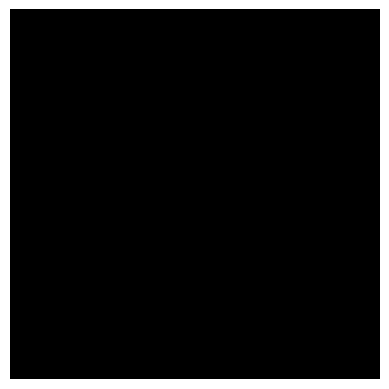

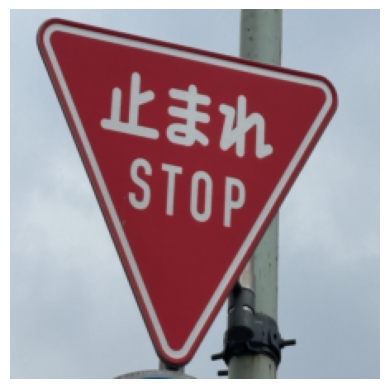

止まれの確率: 69.35299682617188%, 速度制限30km: 30.64699935913086%
予測結果: 止まれ


In [ ]:
'''

ここに止まれの標識を速度制限30kmに誤判定させるようなコードを書いてみましょう（FGSMを使用してください）

'''

# ノイズの強度を指定する（！！！この値を変更する！！！）
eps = 0


# 画像を読み込む

test_image_path = '/content/traffic_sign/test/stop.jpg'
image = Image.open(test_image_path)
image_tensor = composed(image).unsqueeze(0)# デバイスに移動



# ラベルを設定
label = torch.tensor([0])  # デバイスに移動


# FGSM攻撃を行う（！！！ここを追記する！！！）
noise, perturbed_data =  fgsm_attack(test_model, image_tensor, label, eps)
#fgsm_attack関数を使用して攻撃を実施する 例：fgsm_attack(test_model, image_tensor, label, eps)


# 攻撃された画像を表示および保存
# ノイズ画像とノイズが加わった画像を表示および保存
show_and_save_image(noise, "noise_image.jpg")
show_and_save_perturbed_image(perturbed_data, "/content/adversarial_stop_sign_fgsm.jpg")

# 推論を行う
with torch.no_grad():

    output_perturbed = traffic_sign_model(perturbed_data)

    probabilities_perturbed = F.softmax(output_perturbed, dim=1)

    probabilities_perturbed_np = probabilities_perturbed.cpu().numpy()

    probabilities_perturbed_np_rounded = np.round(probabilities_perturbed_np * 100, 3)
    stop_prob = probabilities_perturbed_np_rounded [0][0]
    speed_limit_prob = probabilities_perturbed_np_rounded [0][1]
    print(f"止まれの確率: {stop_prob}%, 速度制限30km: {speed_limit_prob}%")

    predicted_class = torch.argmax(probabilities_perturbed, dim=1).item()

# 結果を表示する
print(f"予測結果: {classes[predicted_class]}")

# Smart Factoryに対する「物理的な」adversarial exampleの実行

In [ ]:
class ImageDot(nn.Module):
    """
    Class to treat an image with translucent color dots.
    forward method creates a blended image of base and color dots.
    Center positions and colors are hard-coded.
    """
    def __init__(self):
        super(ImageDot, self).__init__()
        self.means = [0.485, 0.456, 0.406]
        self.stds = [0.229, 0.224, 0.225]
        self.alpha = 0.03
        self.radius =200.0
        self.beta = 2.0
        self.center = nn.Parameter(torch.rand(2, 2), requires_grad=True)
        self.color = nn.Parameter(torch.rand(2, 3), requires_grad=True)



    def forward(self, x):
        _, _, height, width = x.shape
        blended = x
        for idx in range(self.center.shape[0]):
            mask = self._create_circle_mask(height, width,
                                            self.center[idx] * 255.0, self.beta)
            normalized_color = self._normalize_color(self.color[idx],
                                                     self.means, self.stds)
            blended = self._create_blended_img(blended, mask, normalized_color)
        return blended

    def _normalize_color(self, color, means, stds):
        return list(map(lambda x, m, s: (x - m) / s, color, means, stds))

    def _create_circle_mask(self, height, width, center, beta):
        hv, wv = torch.meshgrid([torch.arange(0, height), torch.arange(0, width)])
        hv, wv = hv.type(torch.FloatTensor), wv.type(torch.FloatTensor)
        d = ((hv - center[0]) ** 2 + (wv - center[1]) ** 2) / self.radius ** 2
        return torch.exp(- d ** beta + 1e-10)

    def _create_blended_img(self, base, mask, color):
        alpha_tile = self.alpha * mask.expand(3, mask.shape[0], mask.shape[1])
        color_tile = torch.zeros_like(base)
        for c in range(3):
            color_tile[:, c, :, :] = color[c]
        return (1. - alpha_tile) * base + alpha_tile * color_tile


class AttackModel(nn.Module):
    """
    Class to create an adversarial example.
    forward method returns the prediction result of the perturbated image.
    """
    def __init__(self):
        super(AttackModel, self).__init__()
        self.image_dot = ImageDot()
        self.base_model = test_model.eval()
        self._freeze_pretrained_model()

    def _freeze_pretrained_model(self):
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.image_dot(x)
        return self.base_model(x)


def compute_loss(pred: torch.Tensor, true_label_idx: int, target_label_idx: int,
                 is_targeted: bool) -> torch.Tensor:
    # Targeted: - loss(true_label) + loss(target_label)
    # Non-targeted: - loss(true_label)
    assert true_label_idx is not None
    true_label_contrib = F.nll_loss(pred, torch.tensor([true_label_idx]))
    if is_targeted:
        target_label_contrib = F.nll_loss(pred, torch.tensor([target_label_idx]))
        return torch.mean(- true_label_contrib + target_label_contrib)  # targeted
    else:
        return torch.mean(- true_label_contrib)  # non-targeted




torch.manual_seed(0)
model = AttackModel()



In [ ]:
# 最適なドットの色と配置を見つけます

#攻撃の設定
'''
赤のキューブを青のキューブに誤判定させたいとき
true_label = 0
targeted_label = 1

青のキューブ赤のキューブに誤判定させたいとき
true_label = 1
targeted_label = 0
'''
true_label = 0
targeted_label = 1


# Load image
test_image_path = '/content/AI_data/test/block (1).jpg'
img_array = io.imread(test_image_path)
transformed_img = composed(PIL.Image.fromarray(img_array))


lr = 0.008
loss_function = nn.NLLLoss()


counter = 0
for epoch in range(500):
    if (epoch + 1) % 50 == 0:
        lr *= 0.5
    model.zero_grad()
    pred = model(transformed_img.unsqueeze(0))
    #loss = compute_loss(pred, 0, -1, False)  # Non-targeted
    loss = compute_loss(pred, true_label, targeted_label, True)  # Targeted
    loss.backward(retain_graph=True)
    counter+=1
    print(f"epoch: {epoch + 1}, loss: {loss.data:.4f},counter: {counter}")

    for param in model.parameters():
        if param.requires_grad == True:
            param.data = torch.clamp(param.data - param.grad.data * lr, min=0.0, max=1.0)

# Save the trained model
dot_model_path = './attack_model.pth'
torch.save(model.image_dot.state_dict(), dot_model_path)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch: 1, loss: 3.5996,counter: 1
epoch: 2, loss: 0.9459,counter: 2
epoch: 3, loss: 0.6280,counter: 3
epoch: 4, loss: 0.1711,counter: 4
epoch: 5, loss: 0.0782,counter: 5
epoch: 6, loss: 0.0534,counter: 6
epoch: 7, loss: 0.0300,counter: 7
epoch: 8, loss: 0.0337,counter: 8
epoch: 9, loss: 0.0073,counter: 9
epoch: 10, loss: 0.0078,counter: 10
epoch: 11, loss: 0.0029,counter: 11
epoch: 12, loss: 0.0014,counter: 12
epoch: 13, loss: -0.0159,counter: 13
epoch: 14, loss: -0.0139,counter: 14
epoch: 15, loss: -0.0346,counter: 15
epoch: 16, loss: -0.0507,counter: 16
epoch: 17, loss: -0.0612,counter: 17
epoch: 18, loss: -0.0896,counter: 18
epoch: 19, loss: -0.1182,counter: 19
epoch: 20, loss: -0.1516,counter: 20
epoch: 21, loss: -0.1870,counter: 21
epoch: 22, loss: -0.2211,counter: 22
epoch: 23, loss: -0.2642,counter: 23
epoch: 24, loss: -0.3003,counter: 24
epoch: 25, loss: -0.3520,counter: 25
epoch: 26, loss: -0.3621,counter: 26
epoch: 27, loss: -0.3781,counter: 27
epoch: 28, loss: -0.3589,counte

KeyboardInterrupt: 

In [ ]:
# もし上のコードを実行しても良いノイズが作れない場合は以下を実行
#!wget -O attack_model.pth https://www.dropbox.com/scl/fi/07cl89xeonj0orwocax43/attack_model.pth?rlkey=gu9nu0jew6kmlnxdsnsl6vrc6&st=pxk80vnc&dl=0

In [ ]:
# 各クラスの名前
classes = ['red', 'blue']

# Load image
test_image_path = '/content/AI_data/test/block (1).jpg'
img_array = io.imread(test_image_path)
transformed_img = composed(PIL.Image.fromarray(img_array))

# Load the saved model
image_dot_model = ImageDot()
image_dot_model.load_state_dict(torch.load('./attack_model.pth'))
image_dot_model.eval()



image = Image.open(test_image_path)
image_tensor =composed(image)
plot_img_from_normalized_img(image_tensor.detach().numpy())

perturbed_img = image_dot_model(image_tensor.unsqueeze(0))
plot_img_from_normalized_img(perturbed_img.squeeze().detach().numpy())

model.image_dot = image_dot_model

with torch.no_grad():
    output =  model(transformed_img.unsqueeze(0))
    probabilities = F.softmax(output, dim=1)
    #Convert the tensor to a numpy array and round it to 3 decimal places
    probabilities_np = probabilities.numpy()
    probabilities_np_rounded = np.round(probabilities_np*100, 2)
    blue_prob = probabilities_np_rounded[0][1]
    red_prob = probabilities_np_rounded[0][0]
    print(f"青の確率: {blue_prob}%, 赤の確率: {red_prob}%")

    predicted_class = torch.argmax(probabilities, dim=1).item()

# 結果を表示する
print(f"Class: {classes[predicted_class]}")